In [1]:
import updated_impyute 
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.metrics import mean_squared_error
import torch
from produce_NA import *
import importlib


C:\Users\Emil\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [13]:
# Function to generate synthetic data

def generate_synthetic_data(n_samples=100, n_features=5):
    mean = np.random.rand(n_features) * 10
    cov = np.random.rand(n_features, n_features)
    cov = np.dot(cov, cov.transpose())  # Ensure the covariance matrix is positive semi-definite
    data = multivariate_normal.rvs(mean=mean, cov=cov, size=n_samples)
    return data

In [3]:
# Generate synthetic data
data = generate_synthetic_data(n_samples=10000, n_features=5)
missing_data_info = produce_NA(data, 0.60 , mecha="MCAR")
X_incomp = missing_data_info['X_incomp'].numpy()

In [4]:
test = updated_impyute.em(X_incomp, eps=0.1)

In [5]:
print(mean_squared_error(data, test))

1.0143634739676153


In [6]:
def nan_covariance(data): #not sure how to initialise without a function like this, np.cov() does not work well as there is alot of NaN in the matrix
    n, m = data.shape # this function basicaly computes covariance ignoring the mssiing data
    means = np.nanmean(data, axis=0)
    data_filled = np.where(np.isnan(data), means, data)

    return np.cov(data_filled, rowvar=False)

In [7]:
print(nan_covariance(X_incomp))

[[0.63675175 0.08693125 0.0695888  0.10760222 0.12982642]
 [0.08693125 0.88026908 0.14414418 0.15055419 0.09165085]
 [0.0695888  0.14414418 0.64791368 0.12615595 0.10167877]
 [0.10760222 0.15055419 0.12615595 1.2386537  0.11307071]
 [0.12982642 0.09165085 0.10167877 0.11307071 0.53376201]]


In [8]:
def log_likelihood1(X, mu, Sigma):
    N=X.shape[0]
    p=X.shape[1]
    result=-N/2*np.log(np.linalg.det(Sigma))
    X_muT=X-mu.T
    for n in range(N):
        result=result-0.5*(X[n,:]-mu.T).dot(np.linalg.solve(Sigma, X[n,:].T-mu)) #is repetitively summing here bad?
    return result

In [9]:
def calculate_xhat(xn,mu,Sigma,missing_indices):
    #m=missing_indices.shape[0]
    p=Sigma.shape[0]
    
    xhatn=xn.copy()
    observed_indices=np.arange(p)[~np.isin(np.arange(p),missing_indices)]
    #appended_indices=np.append(observed_indices, missing_indices)
    
    Sigma22=Sigma[missing_indices,:][:,missing_indices]
    Sigma11=Sigma[observed_indices,:][:,observed_indices]
    Sigma21=Sigma[missing_indices,:][:,observed_indices]
    
    mu1=mu[observed_indices]
    mu2=mu[missing_indices]
    xhatn_1=xhatn[observed_indices]
    mu2_conditional=mu2+Sigma21.dot(np.linalg.solve(Sigma11,xhatn_1-mu1))
    #print(xhatn)
    #print(mu2_conditional,xhatn[missing_indices,],mu2_conditional.shape,xhatn[missing_indices,].shape)
    xhatn[missing_indices,] = mu2_conditional
    #this doesnt seem to work 
    #reason: Array is passed as a view, potential danger!
    #hmm still doesnt work wtf
    #Its because a numpy array of ints rounds floats that are added to it wtfffff, fixed now
    
    #print(xhatn.base)
    #print(mu2_conditional,xhatn[missing_indices])
    
    return xhatn

In [10]:
import numpy as np

def regularize_covariance(Sigma,eigenvalue_tol=1e-2,ridge_coefficient=5e-1,verbose=True):
    
    """
    regularizes covariance matrices with very small eigenvalues by adding lambda*In
    
    Sigma: (p,p) numpy array (positive definite covariance matrix, must be possible to do eigenvalue decomposition)
    
    eigenvalue_tol : threshold of the smallest eigenvalue that leads to regularization
    
    ridge_coefficient : the lambda such that lambda*In gets added if the threshold is reached
    """
    
    eigenvalues, eigenvectors = np.linalg.eig(Sigma)
    #eigenvectors are in the columns
    p=Sigma.shape[0]
    
    small_indices=np.where(eigenvalues<eigenvalue_tol)
    if verbose:
        print("The eigenvectors are the columns of :\n",eigenvectors)
        print("The smallest eigenvalue is :",min(eigenvalues))
        print("The eigenvalues below the tolerance of ", eigenvalue_tol," are :\n",eigenvalues[small_indices])
        print("We added ",ridge_coefficient," to the diagonal.")
    if len(small_indices)>0:
        Sigma=Sigma+ridge_coefficient*np.eye(p)
    return Sigma

In [11]:
def calculate_C(Sigma,missing_indices,verbose=False):
    p=Sigma.shape[0]
    m=missing_indices.shape[0]
    if verbose:
        print("Original unconditional covariance : \n",Sigma)
    observed_indices=np.arange(p)[~np.isin(np.arange(p),missing_indices)]
    appended_indices=np.append(observed_indices, missing_indices)
    Sigma=(Sigma[appended_indices,:])[:,appended_indices]
    
    if verbose:
        print("Unconditional covariance rearranged so that missing indices are at the bottom : \n",Sigma)
    Sigma11=Sigma[0:(p-m),0:(p-m)]
    Sigma21=Sigma[(p-m):p,0:(p-m)]
    Sigma22=Sigma[(p-m):p,(p-m):p]
    Sigma22_conditional=Sigma22-Sigma21.dot(np.linalg.solve(Sigma11,Sigma21.T))
    
    reverse_permutation=np.argsort(appended_indices)
    result=np.full((p,p),0)
    result[(p-m):p,(p-m):p]=Sigma22_conditional
    if verbose:
        print("The conditional covariance when ordered is : \n",result)
    result=(result[reverse_permutation,:])[:,reverse_permutation]
    if verbose:
        print("After permuting back we get : \n", result)
    return(result)

In [12]:
def em_algorithm1(data, max_iter=100, tol=1e-6):
    n, p = data.shape

    # Initialize mean and covariance estimates
    means = np.nanmean(data, axis=0)
    covariance = nan_covariance(data)
    covariance = regularize_covariance(covariance)

    # Create an array to hold imputed data
    imputed_data = np.where(np.isnan(data), np.nanmean(data, axis=0), data)
    #imputed_data = np.where(np.isnan(data), None, data)
    
    old_log_likelihood = log_likelihood1(imputed_data, means, covariance)
    #print(old_log_likelihood)

    for iteration in range(max_iter):
        # E-step: Estimate missing values
        for i in range(n):
            missing = np.where(np.isnan(data[i]))[0]
            if np.isnan(data[i]).any():
                imputed_data[i,] = calculate_xhat(imputed_data[i,],means,covariance,missing) #this function works with Nans in the missing entries too, why do we impute?

        # M-step: Update mean and covariance estimates
        means = np.mean(imputed_data, axis=0)
        new_covariance = np.full((p,p),0) 

        # Add the conditional covariance for missing data
        for i in range(n):
            missing = np.where(np.isnan(data[i]))[0]
            #if missing.any(): #with this condition, are you not skipping xhat-mu *(xhat-mu).T when there is no missing data? I think so...
            new_covariance = new_covariance + calculate_C(covariance,missing,verbose=False) + (imputed_data[i,]-means).reshape(-1, 1) @ np.transpose((imputed_data[i,]-means).reshape(-1, 1))
            
        covariance = new_covariance/n 
        covariance = regularize_covariance(covariance)
        #print(covariance)
        # Convergence test based on log likelihood
        new_log_likelihood = log_likelihood1(imputed_data, means, covariance)
        #print(new_log_likelihood)
        difference=new_log_likelihood - old_log_likelihood
        #print("The new log likelihood is :", new_log_likelihood, "  Difference of : ",difference)
        
        if np.abs(difference) < tol: #absolute value not necessary and potentially undesirable, as in theory should always be positive
            #print("Convergence achieved! \n")
            break
        old_log_likelihood = new_log_likelihood

    return imputed_data,means,covariance

In [208]:
imputed_data, _, _ = em_algorithm1(X_incomp)

In [209]:
print(mean_squared_error(data, imputed_data))

1.6708724650269011


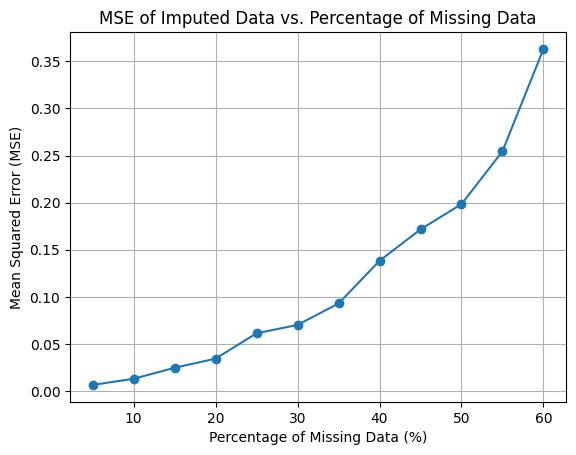

In [231]:
# Generate synthetic data
data = generate_synthetic_data(n_samples=1000, n_features=5)

# Range of missing data percentages
missing_data_percentages = np.arange(5, 65, 5)
mse_values = []

# Loop over different percentages of missing data
for p_miss in missing_data_percentages:
    # Simulate missing data
    missing_data_info = produce_NA(data, p_miss / 100.0)
    X_incomp = missing_data_info['X_incomp'].numpy()

    # Apply EM algorithm
    imputed_data, _, _ = em_algorithm1(X_incomp)
    #imputed_data = updated_impyute.em(X_incomp, eps=0.1)

    # Calculate MSE
    mse = mean_squared_error(data, imputed_data)
    mse_values.append(mse)

# Plotting the results
plt.plot(missing_data_percentages, mse_values, marker='o')
plt.xlabel('Percentage of Missing Data (%)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE of Imputed Data vs. Percentage of Missing Data')
plt.grid(True)
plt.show()

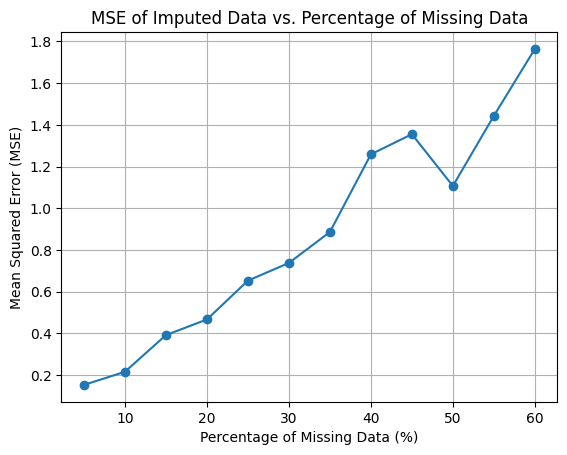

In [228]:
# Range of missing data percentages
missing_data_percentages = np.arange(5, 65, 5)
mse_values = []

# Loop over different percentages of missing data
for p_miss in missing_data_percentages:
    # Simulate missing data
    p_obs = 0.5
    missing_data_info = produce_NA(data, p_miss / 100.0, mecha='MAR', p_obs=p_obs, opt = "quantile")
    X_incomp = missing_data_info['X_incomp'].numpy()

    # Apply EM algorithm
    #imputed_data, _, _ = em_algorithm1(X_incomp)
    imputed_data = updated_impyute.em(X_incomp, eps=0.1)

    # Calculate MSE
    mse = mean_squared_error(data, imputed_data)
    mse_values.append(mse)

# Plotting the results
plt.plot(missing_data_percentages, mse_values, marker='o')
plt.xlabel('Percentage of Missing Data (%)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE of Imputed Data vs. Percentage of Missing Data')
plt.grid(True)
plt.show()

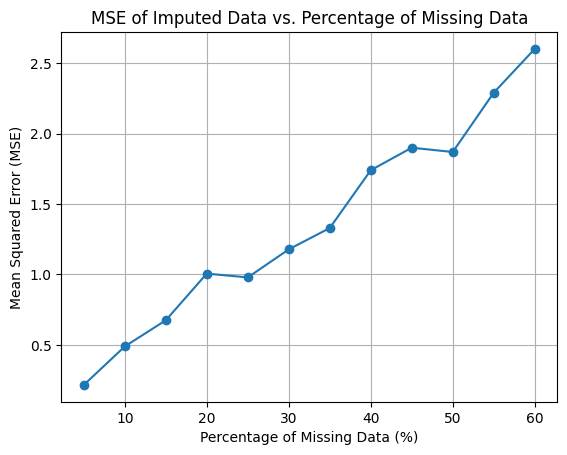

In [229]:
# Range of missing data percentages
missing_data_percentages = np.arange(5, 65, 5)
mse_values = []

# Loop over different percentages of missing data
for p_miss in missing_data_percentages:
    # Simulate missing data
    p_obs = 0.2
    q = 0.7
    missing_data_info = produce_NA(data, p_miss / 100.0, mecha='MNAR',p_obs=p_obs, q=q, opt = "logistic")
    X_incomp = missing_data_info['X_incomp'].numpy()

    # Apply EM algorithm
    #imputed_data, _, _ = em_algorithm1(X_incomp)
    imputed_data = updated_impyute.em(X_incomp, eps=0.1)

    # Calculate MSE
    mse = mean_squared_error(data, imputed_data)
    mse_values.append(mse)

# Plotting the results
plt.plot(missing_data_percentages, mse_values, marker='o')
plt.xlabel('Percentage of Missing Data (%)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE of Imputed Data vs. Percentage of Missing Data')
plt.grid(True)
plt.show()

c:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\impute\_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
c:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\impute\_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
c:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\impute\_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
c:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\impute\_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
c:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\impute\_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.w

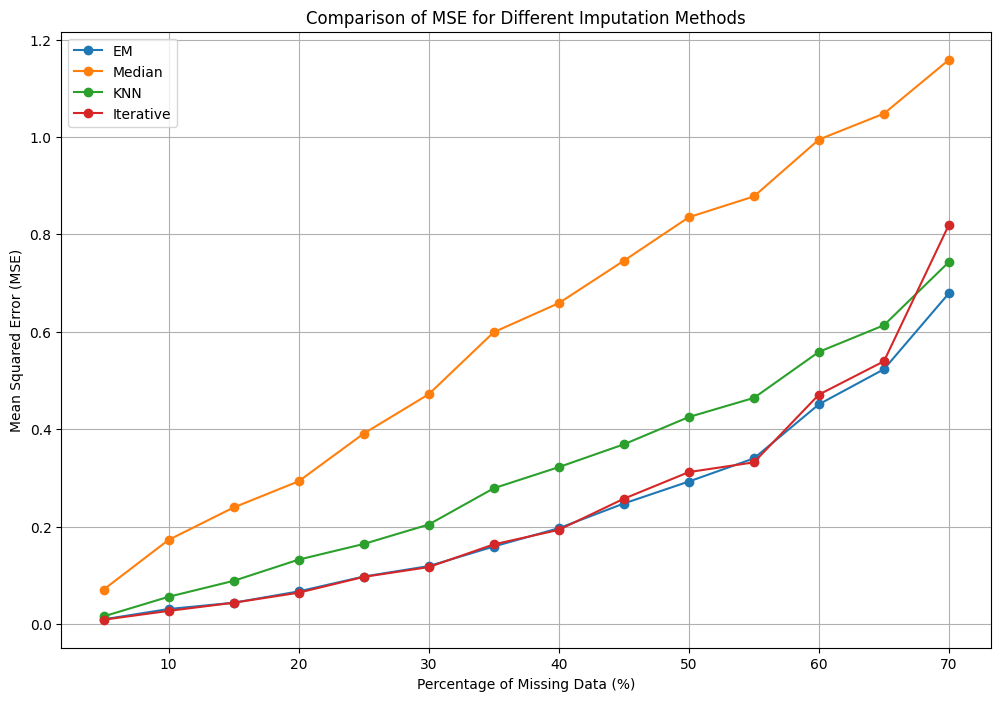

In [257]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Generate synthetic data
data = generate_synthetic_data(n_samples=1000, n_features=5)

# Range of missing data percentages
missing_data_percentages = np.arange(5, 75, 5)
methods = ['EM', 'Median', 'KNN', 'Iterative']
mse_values = {method: [] for method in methods}

# Loop over different percentages of missing data
for p_miss in missing_data_percentages:
    missing_data_info = produce_NA(data, p_miss / 100.0)
    X_incomp = missing_data_info['X_incomp'].numpy()

    # EM Algorithm
    imputed_data_em, _, _ = em_algorithm1(X_incomp)
    mse_values['EM'].append(mean_squared_error(data, imputed_data_em))

    # Median Imputation
    imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
    imputed_data_median = imp_median.fit_transform(X_incomp)
    mse_values['Median'].append(mean_squared_error(data, imputed_data_median))

    # KNN Imputation
    imp_knn = KNNImputer(n_neighbors=5)
    imputed_data_knn = imp_knn.fit_transform(X_incomp)
    mse_values['KNN'].append(mean_squared_error(data, imputed_data_knn))

    # Iterative Imputer (Multivariate feature imputation)
    imp_iterative = IterativeImputer(max_iter=100)
    imputed_data_iterative = imp_iterative.fit_transform(X_incomp)
    mse_values['Iterative'].append(mean_squared_error(data, imputed_data_iterative))


# Plotting the results
plt.figure(figsize=(12, 8))
for method in methods:
    plt.plot(missing_data_percentages, mse_values[method], marker='o', label=method)

plt.xlabel('Percentage of Missing Data (%)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Comparison of MSE for Different Imputation Methods')
plt.legend()
plt.grid(True)
plt.show()


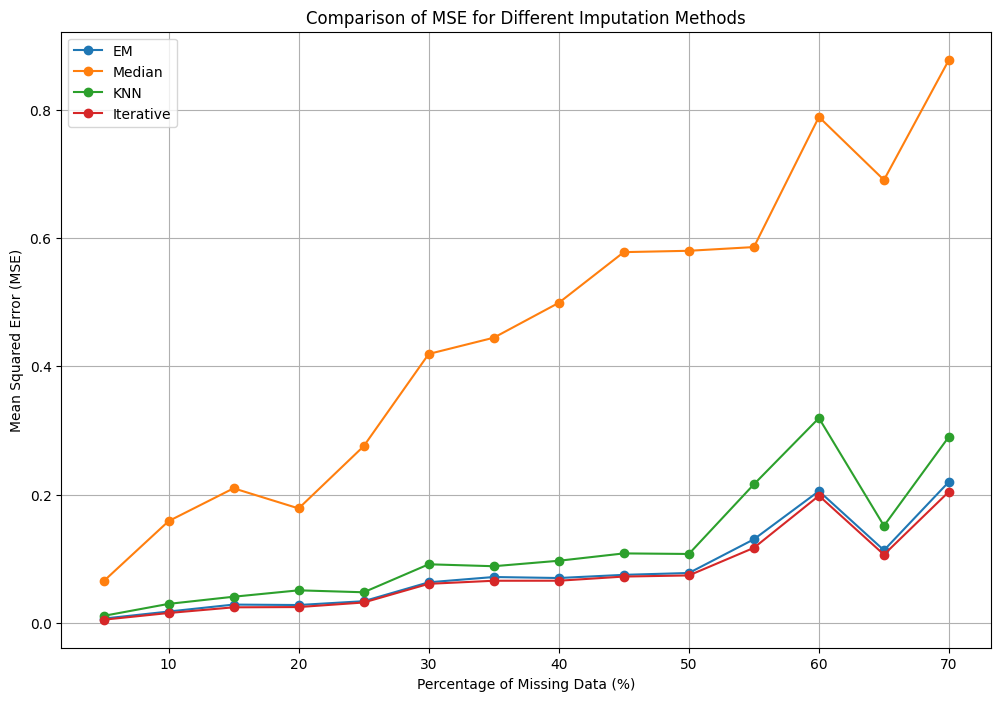

In [258]:
# Range of missing data percentages
missing_data_percentages = np.arange(5, 75, 5)
methods = ['EM', 'Median', 'KNN', 'Iterative']
mse_values = {method: [] for method in methods}

# Loop over different percentages of missing data
for p_miss in missing_data_percentages:
    p_obs = 0.5
    missing_data_info = produce_NA(data, p_miss / 100.0, mecha='MAR', p_obs=p_obs, opt = "quantile")
    X_incomp = missing_data_info['X_incomp'].numpy()

    # EM Algorithm
    imputed_data_em, _, _ = em_algorithm1(X_incomp)
    mse_values['EM'].append(mean_squared_error(data, imputed_data_em))

    # Median Imputation
    imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
    imputed_data_median = imp_median.fit_transform(X_incomp)
    mse_values['Median'].append(mean_squared_error(data, imputed_data_median))

    # KNN Imputation
    imp_knn = KNNImputer(n_neighbors=5)
    imputed_data_knn = imp_knn.fit_transform(X_incomp)
    mse_values['KNN'].append(mean_squared_error(data, imputed_data_knn))

    # Iterative Imputer (Multivariate feature imputation)
    imp_iterative = IterativeImputer(max_iter=100)
    imputed_data_iterative = imp_iterative.fit_transform(X_incomp)
    mse_values['Iterative'].append(mean_squared_error(data, imputed_data_iterative))


# Plotting the results
plt.figure(figsize=(12, 8))
for method in methods:
    plt.plot(missing_data_percentages, mse_values[method], marker='o', label=method)

plt.xlabel('Percentage of Missing Data (%)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Comparison of MSE for Different Imputation Methods')
plt.legend()
plt.grid(True)
plt.show()

c:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\impute\_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
c:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\impute\_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
c:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\impute\_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
c:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\impute\_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
c:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\impute\_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.w

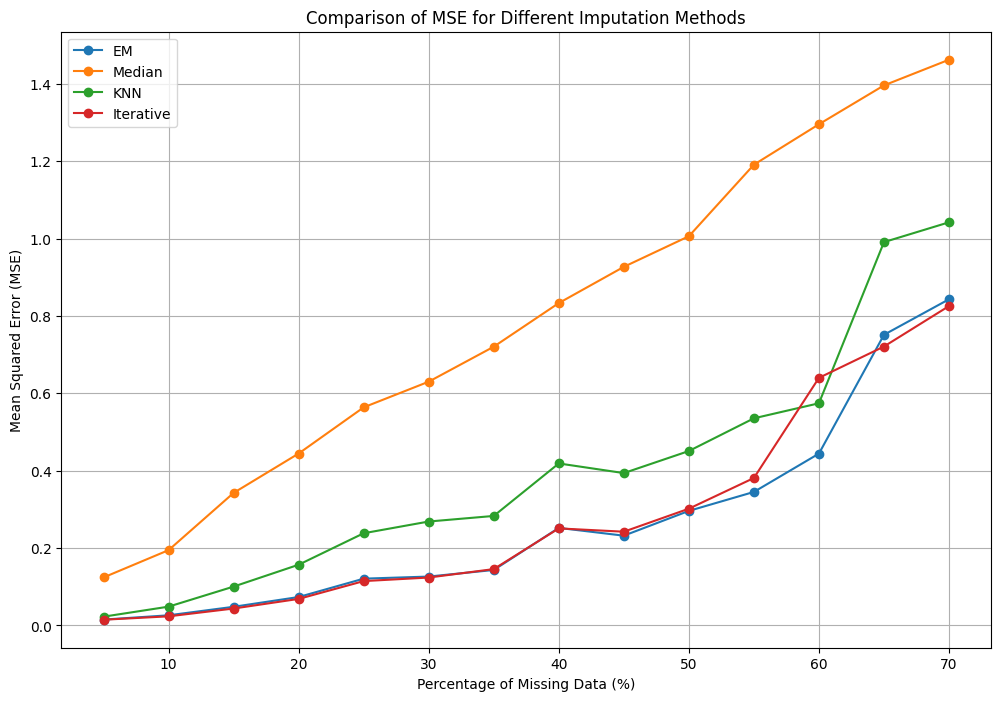

In [259]:
# Range of missing data percentages
missing_data_percentages = np.arange(5, 75, 5)
methods = ['EM', 'Median', 'KNN', 'Iterative']
mse_values = {method: [] for method in methods}

# Loop over different percentages of missing data
for p_miss in missing_data_percentages:
    p_obs = 0.2
    q = 0.7
    missing_data_info = produce_NA(data, p_miss / 100.0, mecha='MNAR',p_obs=p_obs, q=q, opt = "logistic")
    X_incomp = missing_data_info['X_incomp'].numpy()

    # EM Algorithm
    imputed_data_em, _, _ = em_algorithm1(X_incomp)
    mse_values['EM'].append(mean_squared_error(data, imputed_data_em))

    # Median Imputation
    imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
    imputed_data_median = imp_median.fit_transform(X_incomp)
    mse_values['Median'].append(mean_squared_error(data, imputed_data_median))

    # KNN Imputation
    imp_knn = KNNImputer(n_neighbors=5)
    imputed_data_knn = imp_knn.fit_transform(X_incomp)
    mse_values['KNN'].append(mean_squared_error(data, imputed_data_knn))

    # Iterative Imputer (Multivariate feature imputation)
    imp_iterative = IterativeImputer(max_iter=100)
    imputed_data_iterative = imp_iterative.fit_transform(X_incomp)
    mse_values['Iterative'].append(mean_squared_error(data, imputed_data_iterative))


# Plotting the results
plt.figure(figsize=(12, 8))
for method in methods:
    plt.plot(missing_data_percentages, mse_values[method], marker='o', label=method)

plt.xlabel('Percentage of Missing Data (%)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Comparison of MSE for Different Imputation Methods')
plt.legend()
plt.grid(True)
plt.show()

The eigenvectors are the columns of :
 [[-1.74624228e-03 -6.79322974e-03  1.42133957e-03  3.71378578e-01
  -9.22767056e-01 -4.14731042e-02  6.68802298e-02 -3.50779658e-03
  -6.07337312e-04  6.04531310e-02  2.58347181e-02 -1.55734413e-04]
 [-1.18894765e-04 -1.05264522e-03 -3.28671694e-04 -1.76369283e-03
   1.60886309e-02  3.54459471e-02 -1.09164602e-01 -1.37862979e-03
   2.39133505e-04  1.97647604e-01  4.81669496e-01  8.45867279e-01]
 [-1.80709082e-04 -1.31825149e-03 -1.33447485e-04 -2.99593675e-03
  -5.27624852e-02  3.21073968e-03  8.33071252e-02  3.13820494e-02
  -1.30080845e-04 -6.17479013e-01 -6.00212538e-01  4.97729543e-01]
 [-3.48775736e-02 -3.00093417e-02 -9.96266527e-01 -4.91559965e-02
  -2.24309630e-02  4.82307952e-02  9.12681959e-03 -4.72062036e-04
  -3.54823047e-04  1.00640895e-03  1.35703511e-03 -1.95701673e-03]
 [-7.82541779e-05 -2.61673840e-05 -1.76429109e-04  5.11403095e-03
   3.81068241e-03 -3.27161483e-03 -8.52775406e-03 -9.99304037e-01
  -8.87689969e-03 -1.21460384e-02

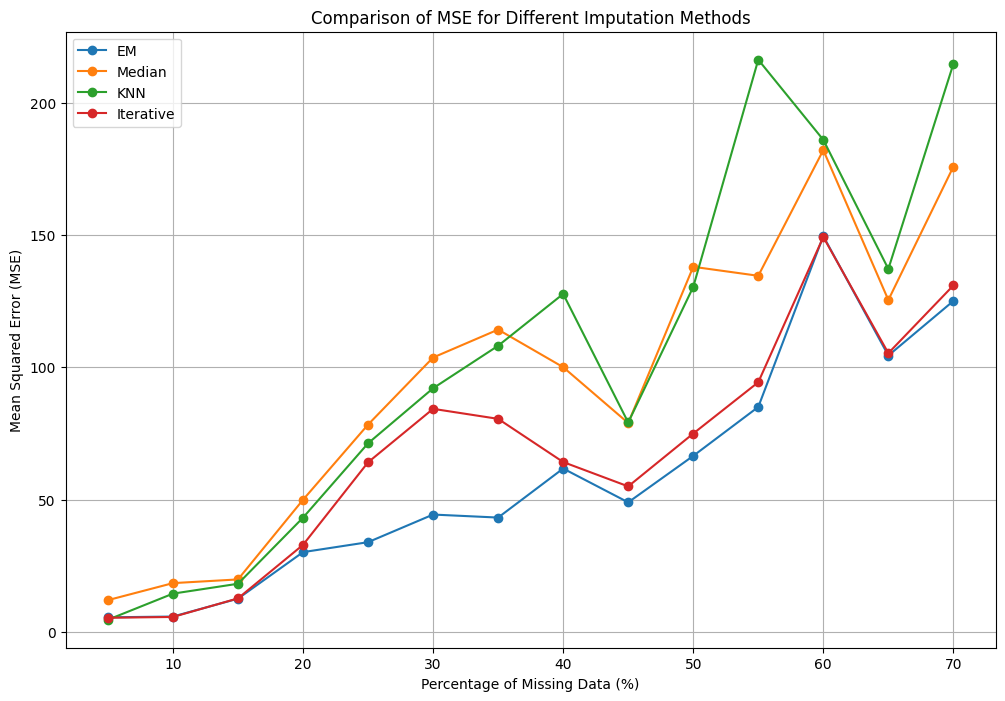

In [274]:
# dataset from https://archive.ics.uci.edu/dataset/186/wine+quality
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Load the Wine Quality dataset
wine_data = pd.read_csv('winequality-white.csv', delimiter=';')
# Take a random subset of 500 samples
wine_data_subset = wine_data.sample(n=200, random_state=124)

# Convert to numpy array
data = wine_data_subset.to_numpy()

# Range of missing data percentages and methods
missing_data_percentages = np.arange(5, 75, 5)
methods = ['EM', 'Median', 'KNN', 'Iterative']
mse_values = {method: [] for method in methods}

# Loop over different percentages of missing data
for p_miss in missing_data_percentages:
    # Simulate missing data
    missing_data_info = produce_NA(data, p_miss / 100.0)
    X_incomp = missing_data_info['X_incomp'].numpy()

    # EM Algorithm
    imputed_data_em, _, _ = em_algorithm1(X_incomp)
    mse_values['EM'].append(mean_squared_error(data, imputed_data_em))

    # Median Imputation
    imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
    imputed_data_median = imp_median.fit_transform(X_incomp)
    mse_values['Median'].append(mean_squared_error(data, imputed_data_median))

    # KNN Imputation
    imp_knn = KNNImputer(n_neighbors=5)
    imputed_data_knn = imp_knn.fit_transform(X_incomp)
    mse_values['KNN'].append(mean_squared_error(data, imputed_data_knn))

    # Iterative Imputer (Multivariate feature imputation)
    imp_iterative = IterativeImputer(max_iter=100)
    imputed_data_iterative = imp_iterative.fit_transform(X_incomp)
    mse_values['Iterative'].append(mean_squared_error(data, imputed_data_iterative))


# Plotting the results
plt.figure(figsize=(12, 8))
for method in methods:
    plt.plot(missing_data_percentages, mse_values[method], marker='o', label=method)

plt.xlabel('Percentage of Missing Data (%)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Comparison of MSE for Different Imputation Methods')
plt.legend()
plt.grid(True)
plt.show()